In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None

Train = True

In [5]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-0:30:00',
                       '#mem=1500M',
                       '#mem-per-cpu=None', 
                       '#job-name="simD"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

In [3]:
N = 250
Ne = 1000
L = 100000
r = 1.25e-7
mu = 2.5e-7
start = 0
Until = 250

Common = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
          'N':N, 'L':L, 'r':r, 'mu':mu,
          'Freq':1000, 'extmut':0, 'Until':Until,
          'srun':srun, 'srun_est':srun_est}

nonsel = {'s':0, 'h':0.5, 'reset_lost': 0}
cnstP = {'Ne':Ne, 'start':Until+10, 'etapath':'etas/cn.json', 'rep':0}

In [4]:
Args = {}
Args['cn'] = {**Common, **nonsel, **cnstP, 'name':'Constant Population Size \nNeutral Mutation'}

cID = 1 # simulation class id for directional selection exponential growth simulations
nrep = 500
X = Experiment(cID, nrep, Args)

In [21]:
if Train:
    X.sim()

If you are using HPC (srun is not None) check the jobs!


In [5]:
X.calc_sfs()
X.train_eta()

Done!


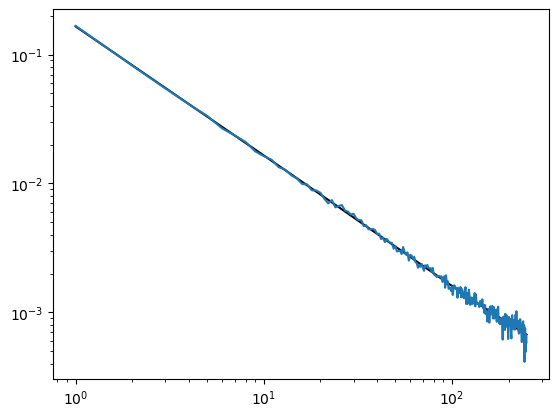

In [6]:
setid = X.setids[0]
name = Args[setid]['name']
plt.plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
plt.plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    
plt.xscale('log')
plt.yscale('log')

In [7]:
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'
jobs = X.est(BIM, setid, now = 30, srun = srun_est, arg = '--r2t=0.005 --r2s=0.001')

If you are using HPC (srun is not None) check the jobs!


In [15]:
X.merge_outs(setid, name = 'outs/fpr.csv')

In [16]:
df = pd.read_csv('outs/fpr.csv')

In [18]:
to = df.shape[0]//2

In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

In [146]:
def CVfpr(df, key, score_ascending = False):
    #x = df[key].sample(frac = 1).to_numpy()
    
    x = np.random.exponential(size = 500)
    y0 = x[:to]
    y1 = x[to:]
    
    if not score_ascending:
        y0 = -y0
        y1 = -y1
    

    leny1 = len(y1)
    leny0 = len(y0)
    y_true = np.r_[np.zeros(leny0), np.ones(leny1)]
    y_score = np.r_[y0, y1]
    fpr, tpr, _ = roc_curve(y_true, y_score,drop_intermediate=False)
    return fpr, tpr

In [147]:
bsfs_fpr_ds = np.array([np.array(CVfpr(df, 'TajD')) for _ in range(1000)])


In [148]:
x = bsfs_fpr_ds.mean(0)

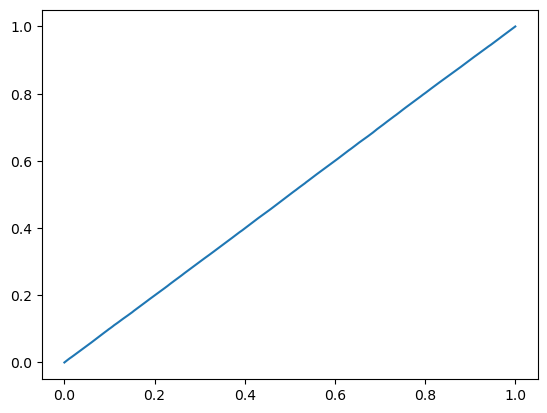

In [149]:
plt.plot(x[0], x[1])
plt.show()

In [109]:
bsfs_fpr_ds

array([[[0.   , 0.   , 0.004, ..., 0.992, 0.996, 1.   ],
        [0.   , 0.004, 0.004, ..., 1.   , 1.   , 1.   ]],

       [[0.   , 0.   , 0.   , ..., 0.992, 0.996, 1.   ],
        [0.   , 0.004, 0.008, ..., 1.   , 1.   , 1.   ]],

       [[0.   , 0.004, 0.004, ..., 0.996, 1.   , 1.   ],
        [0.   , 0.   , 0.004, ..., 0.996, 0.996, 1.   ]],

       ...,

       [[0.   , 0.   , 0.   , ..., 0.996, 1.   , 1.   ],
        [0.   , 0.004, 0.008, ..., 0.996, 0.996, 1.   ]],

       [[0.   , 0.004, 0.008, ..., 0.996, 0.996, 1.   ],
        [0.   , 0.   , 0.   , ..., 0.996, 1.   , 1.   ]],

       [[0.   , 0.004, 0.008, ..., 0.996, 0.996, 1.   ],
        [0.   , 0.   , 0.   , ..., 0.996, 1.   , 1.   ]]])

In [89]:
bsfs_fpr_ds.shape

(1000, 2)

In [79]:
bsfs_fpr_bs = [CVfpr(df, 'bsfs', True) for _ in range(10000)]

TajD_fpr_ds = [CVfpr(df, 'TajD') for _ in range(10000)]
TajD_fpr_bs = [CVfpr(df, 'TajD', True) for _ in range(10000)]

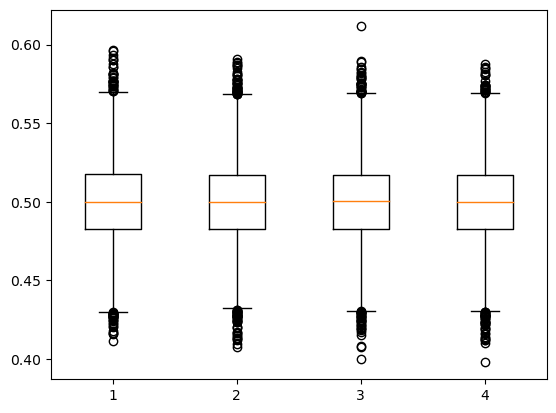

In [80]:
plt.boxplot([bsfs_fpr_ds, bsfs_fpr_bs, TajD_fpr_ds, TajD_fpr_bs])
plt.show()


In [ ]:

df[key][:to]
df[key][:to]

y_true = np.r_[np.zeros(leny0), np.ones(leny1)]
y_score = np.r_[y0, y1]
roc_auc_score(y_true, y_score)

Text(0, 0.5, 'True Positive Rates')

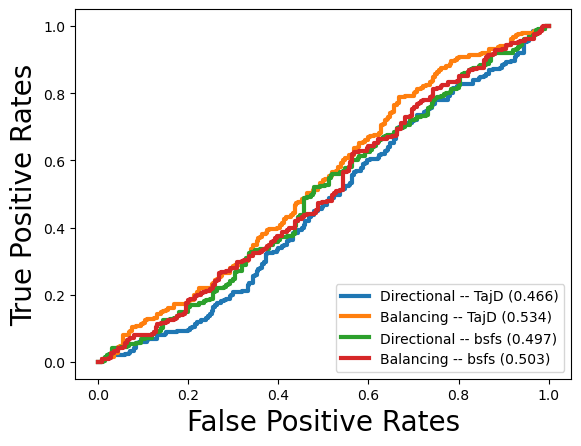

In [25]:
key = 'TajD'
ROC(plt, df[key][:to], df[key][to:], score_ascending = False, label = 'Directional -- TajD')
ROC(plt, df[key][:to], df[key][to:], score_ascending = True, label = 'Balancing -- TajD')

key = 'bsfs'
ROC(plt, df[key][:to], df[key][to:], score_ascending = False, label = 'Directional -- bsfs')
ROC(plt, df[key][:to], df[key][to:], score_ascending = True, label = 'Balancing -- bsfs')
plt.legend(loc = 'lower right')
plt.xlabel('False Positive Rates', size = 20)
plt.ylabel('True Positive Rates', size = 20)

(array([  1.,   1.,   6.,  25.,  49., 108., 133.,  87.,  69.,  21.]),
 array([-1.24716136, -1.10742258, -0.96768379, -0.82794501, -0.68820623,
        -0.54846744, -0.40872866, -0.26898988, -0.12925109,  0.01048769,
         0.15022648]),
 <a list of 10 Patch objects>)

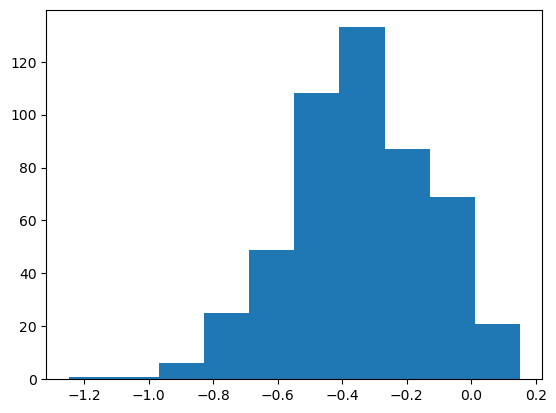

In [66]:
(df['ibtree'])